In [1]:
import os
import numpy as np
import nibabel as nib
from PIL import Image
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from scipy import ndimage

In [110]:
#take  5D matrix, normalize existing mask to class1, perform a crop operation, create an expansion mask

#center of mass calculation
def calc_com_3d(data):
    new_data = data
    dup_mask = data[:,:,:,:,1]>0   #Normalize segmentations to binary mask, any signal gets included in com calculation
    dup_mask = np.sum(dup_mask, axis=3)
    xsum = np.sum(np.sum(dup_mask, axis=1), axis=1)
    ysum = np.sum(np.sum(dup_mask, axis=0), axis=1)
    zsum = np.sum(np.sum(dup_mask, axis=0), axis=0)

    # plt.plot(range(len(xsum)), xsum)
    # plt.plot(range(len(ysum)), ysum)
    # plt.plot(range(len(zsum)), zsum)

    def calc_com_1d(arr):
        wsum = 0
        msum = 0
        for i in range(len(arr)):
            wsum += arr[i]*i
            msum += arr[i]
        if msum == 0:
            return int((len(arr)+1)/2)
        return wsum/msum

    xcom = calc_com_1d(xsum)
    ycom = calc_com_1d(ysum)
    zcom = calc_com_1d(zsum)
    return (int(xcom), int(ycom), int(zcom))

def expand_mask(data, iterations = 10):
    # class_max = np.amax(data[:,:,:,:,1])
    # print('class max = {}'.format(class_max))
    new_data = np.copy(data[:,:,:,:,1]>0)   #Normalize segmentations to binary mask, any signal gets included in com calculation
    if np.amax(new_data) == 0:
        return 0
    assert np.amax(new_data) == 1
    assert len(new_data.shape)==4
    for i in range(data.shape[3]):
        expansion = ndimage.binary_dilation(new_data[:,:,:,i], iterations=iterations)
        data[:,:,:,i,1] = np.add(data[:,:,:,i,1],expansion)
    
    class_max = np.amax(data[:,:,:,:,1])
    print(np.unique(data[:,:,:,:,1]))
    print('class max = {}'.format(class_max))
        

def matrix_process(data, crop_size = (128,128,128), expmask = False, binarize=False):
    assert len(data.shape) == 5, 'data matrix must be 5 dimensional (x,y,x,t,im_label)'
    if binarize==True:
        data[:,:,:,:,1] = data[:,:,:,:,1]>0

    com = calc_com_3d(data)
    
    #CROP
    #ensure dimensions are larger than crop region
    if crop_size[0] >= data.shape[0]:
        diff = crop_size[0]-data.shape[0]
        data = np.pad(data, ((int(diff/2),diff-int(diff/2)), (0,0), (0,0), (0,0), (0,0)), 'constant', constant_values=(0, 0))
        print('padded dim 0 - shape = {}'.format(data.shape))
    if crop_size[1] >= data.shape[1]:
        diff = crop_size[1]-data.shape[1]
        data = np.pad(data, ((0,0), (int(diff/2),diff-int(diff/2)), (0,0), (0,0), (0,0)), 'constant', constant_values=(0, 0))
        print('padded dim 1 - shape = {}'.format(data.shape))
    if crop_size[2] >= data.shape[2]:
        diff = crop_size[2]-data.shape[2]
        data = np.pad(data, ((0,0), (0,0), (int(diff/2),diff-int(diff/2)), (0,0), (0,0)), 'constant', constant_values=(0, 0))
        print('padded dim 2 - shape = {}'.format(data.shape))
    
    #calculate lower and upper crop
    mins = [int(com[i]-crop_size[i]/2) for i in range(len(com))]
    maxs = [int(com[i]+crop_size[i]/2) for i in range(len(com))]
    #ensure no overspill
    for i in range(len(com)):
        if mins[i] < 0:
            maxs[i] -= mins[i]
            mins[i] = 0
        if maxs[i] > data.shape[i]:
            dif = maxs[i]-data.shape[i]
            mins[i] -= dif
            maxs[i] = data.shape[i]
        
    #crop
    data = data[mins[0]:maxs[0],mins[1]:maxs[1],mins[2]:maxs[2],:,:]
    
    
    #add expansion mask
    expand_mask(data)
    
    return data

In [109]:
# Load a 4D image (.nii) and preprocess: crop to a set region around the segmentation mask and add a expansion mask (?) to the mask classes
#Also reform mask classes - for now set all nonzero classes = 1, with possible expansion mask = 2

# savedir = 'TAV/4d_preprocessed'
savedir = 'data/multi-class/4d'
readdir = 'data/BAV'
segimgs = []
for img_path in tqdm(sorted(glob.glob(readdir+"/images/*.nii.gz")), leave=True):
    seg_path = readdir+"/segmentations/{}.nii.gz".format(os.path.split(img_path)[1][:-12])
    
    if os.path.exists('{}/{}'.format(savedir,img_path)):
        print('path {} exists'.format('{}/images/{}'.format(savedir, os.path.split(img_path)[1])))
        continue
    
    if not os.path.exists(seg_path):
        print("ERROR segpath unfound: {}".format(seg_path))
        continue
    img = nib.load(img_path)
    imgdata = img.get_fdata()
    seg = nib.load(seg_path)
    segdata = seg.get_fdata()
    
    print(np.unique(data[:,:,:,:,1]))
    
    if imgdata.shape != segdata.shape:
        print("ERROR SHAPE MISMATCH: {}: img: {}, seg: {}".format(img_path, imgdata.shape, segdata.shape))
        print('processing up to frame {}'.format(segdata.shape[3]))
        imgdata = imgdata[:,:,:,:segdata.shape[3]]
        # continue
        
    # #Make segdata a binary mask instead of multiclass
    # segdata = segdata>0
        
    data = np.stack((imgdata,segdata), axis = 4)
        
    #run preprocessing
    data = matrix_process(data)
    
    #save to nii
    newimg = nib.Nifti1Image(data[:,:,:,:,0], np.eye(4))
    newseg = nib.Nifti1Image(data[:,:,:,:,1], np.eye(4))
    
    newimgpath = '{}/images/{}'.format(savedir, os.path.split(img_path)[1])
    newsegpath = '{}/segmentations/{}'.format(savedir, os.path.split(seg_path)[1])
        
    nib.save(newimg, newimgpath)
    nib.save(newseg, newsegpath)

  0%|                                                                                                                                                                                | 0/21 [00:00<?, ?it/s]

[0. 4.]
[0. 1. 5.]
class max = 5.0


  5%|████████                                                                                                                                                                | 1/21 [00:41<13:49, 41.45s/it]

[0. 1. 5.]
[0. 1. 5.]
class max = 5.0


 10%|████████████████                                                                                                                                                        | 2/21 [00:56<08:13, 25.95s/it]

[0. 1. 5.]
ERROR SHAPE MISMATCH: data/BAV/images/bav03_4d_0000.nii.gz: img: (176, 208, 208, 61), seg: (176, 208, 208, 31)
processing up to frame 31
[0. 1. 5.]
class max = 5.0


 14%|████████████████████████                                                                                                                                                | 3/21 [01:23<07:58, 26.56s/it]

[0. 1. 5.]
[0. 1. 5.]
class max = 5.0


 19%|████████████████████████████████                                                                                                                                        | 4/21 [01:57<08:17, 29.28s/it]

[0. 1. 5.]
ERROR SHAPE MISMATCH: data/BAV/images/bav05_4d_0000.nii.gz: img: (224, 192, 208, 26), seg: (224, 192, 208, 13)
processing up to frame 13
[0. 1. 5.]
class max = 5.0


 24%|████████████████████████████████████████                                                                                                                                | 5/21 [02:16<06:51, 25.72s/it]

[0. 1. 5.]
ERROR SHAPE MISMATCH: data/BAV/images/bav07_4d_0000.nii.gz: img: (208, 176, 224, 16), seg: (208, 176, 224, 9)
processing up to frame 9
[0. 1. 5.]
class max = 5.0


 29%|████████████████████████████████████████████████                                                                                                                        | 6/21 [02:25<04:57, 19.82s/it]

[0. 1. 5.]
ERROR SHAPE MISMATCH: data/BAV/images/bav08_4d_0000.nii.gz: img: (176, 176, 208, 68), seg: (176, 176, 208, 26)
processing up to frame 26
[0. 1. 5.]
class max = 5.0


 33%|████████████████████████████████████████████████████████                                                                                                                | 7/21 [02:46<04:47, 20.51s/it]

[0. 1. 5.]
ERROR SHAPE MISMATCH: data/BAV/images/bav09_4d_0000.nii.gz: img: (176, 176, 208, 27), seg: (176, 176, 208, 16)
processing up to frame 16
[0. 1. 5.]
class max = 5.0


 38%|████████████████████████████████████████████████████████████████                                                                                                        | 8/21 [03:02<04:07, 19.05s/it]

[0. 1. 5.]
ERROR SHAPE MISMATCH: data/BAV/images/bav10_4d_0000.nii.gz: img: (176, 208, 208, 57), seg: (176, 208, 208, 20)
processing up to frame 20
[0. 1. 5.]
class max = 5.0


 43%|████████████████████████████████████████████████████████████████████████                                                                                                | 9/21 [03:22<03:48, 19.08s/it]

[0. 1. 5.]
[0. 1. 5.]
class max = 5.0


 48%|███████████████████████████████████████████████████████████████████████████████▌                                                                                       | 10/21 [03:41<03:32, 19.29s/it]

[0. 1. 5.]
[0. 1. 5.]
class max = 5.0


 52%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 11/21 [03:58<03:04, 18.44s/it]

[0. 1. 5.]
ERROR SHAPE MISMATCH: data/BAV/images/bav13_4d_0000.nii.gz: img: (176, 208, 224, 58), seg: (176, 208, 224, 30)
processing up to frame 30
[0. 1. 5.]
class max = 5.0


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 12/21 [04:23<03:05, 20.57s/it]

ERROR segpath unfound: data/BAV/segmentations/bav14_4d.nii.gz
[0. 1. 5.]
ERROR SHAPE MISMATCH: data/BAV/images/bav16_4d_0000.nii.gz: img: (224, 144, 208, 79), seg: (224, 144, 208, 40)
processing up to frame 40
[0. 1. 5.]
class max = 5.0


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 14/21 [04:59<02:14, 19.20s/it]

ERROR segpath unfound: data/BAV/segmentations/bav17_4d.nii.gz
[0. 1. 5.]
[0. 1. 5.]
class max = 5.0


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 16/21 [05:33<01:31, 18.34s/it]

[0. 1. 5.]
ERROR SHAPE MISMATCH: data/BAV/images/bav20_4d_0000.nii.gz: img: (176, 112, 208, 34), seg: (176, 112, 208, 26)
processing up to frame 26
padded dim 1 - shape = (176, 128, 208, 26, 2)
[0. 1. 5.]
class max = 5.0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 17/21 [05:54<01:15, 18.94s/it]

[0. 1. 5.]
[0. 1. 5.]
class max = 5.0


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 18/21 [06:08<00:53, 17.93s/it]

[0. 1. 5.]
ERROR SHAPE MISMATCH: data/BAV/images/bav24_4d_0000.nii.gz: img: (176, 176, 224, 19), seg: (176, 176, 224, 13)
processing up to frame 13
[0. 1. 5.]
class max = 5.0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 19/21 [06:19<00:31, 15.94s/it]

[0. 1. 5.]
ERROR SHAPE MISMATCH: data/BAV/images/bav25_4d_0000.nii.gz: img: (176, 176, 224, 19), seg: (176, 176, 224, 10)
processing up to frame 10
[0. 1. 5.]
class max = 5.0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 20/21 [06:26<00:13, 13.63s/it]

[0. 1. 5.]
padded dim 1 - shape = (224, 128, 208, 24, 2)
[0. 1. 5.]
class max = 5.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [06:42<00:00, 19.17s/it]


In [347]:
# FOR loading time series of 3D Masks (niii) and saving them as 4D images (.nii)
filepath = "TAV/segmentations/*/"

segimgs = []
for sequence_path in tqdm(sorted(glob.glob(filepath)), leave=True):
    temp = []
    for img_path in sorted(glob.glob("{}/*.nii.gz".format(sequence_path))):
        img = nib.load(img_path)
        imgdata = img.get_fdata()
        temp.append(imgdata)
    temp = np.transpose(np.array(temp), (1,2,3,0))
    # print("{} loaded with shape {}".format(img_path,temp.shape))
    
    data = temp.astype(np.int16)
    img = nib.Nifti1Image(data, np.eye(4)) # np.eye(4) is a 4 dimensional image coordinate transformation
    nib.save(img, '{}_4d.nii.gz'.format(sequence_path[:-1]))
    
print('complete')

100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:29<00:00,  8.92s/it]

complete


In [75]:
# FOR loading 4D images (.nii) and saving them as time series of 3D images (.nii)

readdir = 'data/multi-class/4d'
segorimg = 'seg' # 'seg', 'img'

if segorimg == 'seg':
    globpath = readdir+"/segmentations/*.nii.gz"
else:
    globpath = readdir+"/images/*.nii.gz" #"4d_preprocessed/images/*.nii.gz"


segimgs = []
for img_path in tqdm(sorted(glob.glob(globpath)), leave=True):
    if segorimg == 'seg':
        savedir = '{}'.format(os.path.splitext(os.path.splitext(img_path)[0])[0][:-3]) #for segmentation path
    else:
        savedir = '{}'.format(os.path.splitext(os.path.splitext(img_path)[0])[0][:-8]) #for image path

    if os.path.exists(savedir) == False:
        os.mkdir(savedir)
        
    img = nib.load(img_path)
    imgdata = img.get_fdata()
    for i in range(np.size(imgdata, axis=3)):
        data = imgdata[:,:,:,i].astype(np.int16)
        img = nib.Nifti1Image(data, np.eye(4)) # np.eye(4) is a 4 dimensional image coordinate transformation
        
        if segorimg == 'seg':
            save_path = '{}/{}_{}.nii.gz'.format(savedir, 
                                                    os.path.split(savedir)[1],
                                                    str(i+1).zfill(3)) #for segmentation
        else:
            save_path = '{}/{}_{}_0000.nii.gz'.format(savedir, 
                                                    os.path.split(savedir)[1],
                                                    str(i+1).zfill(3)) #for images
        
        nib.save(img, save_path)
        
    # print("{} saved with {} frames".format(img_path,np.size(imgdata, axis=3)))
    
print('complete')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:24<00:00,  1.17it/s]

complete


load in 4d image and segmentation niis as numpy arrays
concatenate to create one 5 d array - (x, y, z, time, img_or_label)

find center of mass of the segmentation mask based on (for each spatial dimension, along each dimension, take the sum of mask values and multiply by the index number, divide by the length of that dimension to get the center of mass index

make all nonzero values of the mask = 1
expansion mask: duplicate mask array, add a (dilation or blur, set all values past threshold = 1), add to the mask layer

crop - try a 64x64x64 cube? i dunno

data/BAV/images/bav01/bav01_001_0000.nii.gz
z = 94


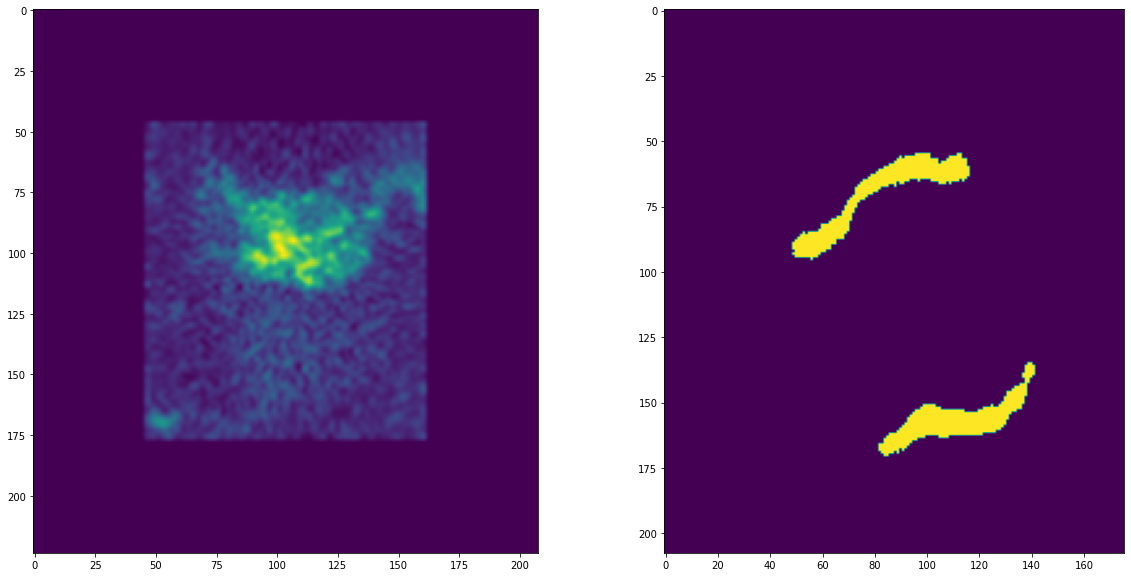

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 4. 4. 4. 4. 4. 4. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [164]:
#TESTER CELL
import random

img_paths = sorted(glob.glob('data/multi-class/3d/images/*/*.nii.gz'))
seg_paths = sorted(glob.glob('data/multi-class/3d/segmentations/*/*.nii.gz'))
img_paths = sorted(glob.glob('data/BAV/images/*/*.nii.gz'))
seg_paths = sorted(glob.glob('data/BAV/segmentations/*/*.nii.gz'))
seg_paths = ['data/seg05_to_09_bav07_root_reslice.nii.gz']
randindex = int(random.random()*len(seg_paths))

img = nib.load(img_paths[randindex])
imgdata = img.get_fdata()

seg = nib.load(seg_paths[randindex])
segdata = seg.get_fdata()

# rand_timeframe = int(random.random()*imgdata.shape[3])
rand_slice_pos = int(random.random()*imgdata.shape[2])

print(img_paths[randindex])
print('z = {}'.format(rand_slice_pos))


fig, axs = plt.subplots(1, 2, figsize = (20,10))
axs[0].imshow(imgdata[:,:,rand_slice_pos])#,rand_timeframe])
axs[1].imshow(segdata[:,:,rand_slice_pos])#,rand_timeframe])
plt.show()

print(segdata[:,80,rand_slice_pos])

In [147]:
import vtk
from vtk.util.numpy_support import vtk_to_numpy

imr = vtk.vtkMetaImageReader()
imr.SetFileName('t10-Subvolume-resample_scale-1.mhd')
imr.Update()

im = imr.GetOutput()
rows, cols, _ = im.GetDimensions()
sc = im.GetPointData().GetScalars()
a = vtk_to_numpy(sc)
a = a.reshape(rows, cols, -1)

assert a.shape==im.GetDimensions()


ModuleNotFoundError: No module named 'vtk'

In [11]:
# FOR loading 4D images (.nii) and saving them as time series of 3D images (.nii)
from skimage.io import imsave

segorimg = 'seg' # 'seg', 'img'

if segorimg == 'seg':
    globpath = "4d_preprocessed/segmentations/*.nii.gz"
else:
    globpath = "4d_preprocessed/images/*.nii.gz" #"4d_preprocessed/images/*.nii.gz"


segimgs = []
for img_path in tqdm(sorted(glob.glob(globpath)), leave=True):
    
    if segorimg == 'seg':
        savedir = '{}'.format(os.path.splitext(os.path.splitext(img_path)[0])[0][:-3]) #for segmentation path
    else:
        savedir = '{}'.format(os.path.splitext(os.path.splitext(img_path)[0])[0][:-8]) #for image path

    if os.path.exists(savedir) == False:
        os.mkdir(savedir)
        
    img = nib.load(img_path)
    imgdata = img.get_fdata()
    for i in range(np.size(imgdata, axis=3)):
        data = imgdata[:,:,:,i].astype(np.int8)
        # img = nib.Nifti1Image(data, np.eye(4)) # np.eye(4) is a 4 dimensional image coordinate transformation
        
        if segorimg == 'seg':
            save_path = '{}/{}_{}.tif'.format(savedir, 
                                                    os.path.split(savedir)[1],
                                                    str(i+1).zfill(3)) #for segmentation
        else:
            save_path = '{}/{}_{}_0000.tif'.format(savedir, 
                                                    os.path.split(savedir)[1],
                                                    str(i+1).zfill(3)) #for images
        
        # tif.imsave(save_path, data, bigtiff=True)
        imsave(save_path, data)
        # nib.save(img, save_path)
        
    # print("{} saved with {} frames".format(img_path,np.size(imgdata, axis=3)))
    
print('complete')

  0%|                                                                                                                                                                                | 0/19 [00:00<?, ?it/s]/Users/trevorchan/environments/echo/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: 4d_preprocessed/segmentations/bav01/bav01_001.tif is a low contrast image
/Users/trevorchan/environments/echo/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: 4d_preprocessed/segmentations/bav01/bav01_002.tif is a low contrast image
/Users/trevorchan/environments/echo/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: 4d_preprocessed/segmentations/bav01/bav01_003.tif is a low contrast image
/Users/trevorchan/environments/echo/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: 4d_preprocessed/segmentations/bav01/bav01_004.tif is a low contrast image
/Users/trevorchan/environments/echo/lib/python3.7/site-packages/ipykernel_launcher.py:39

complete


In [13]:
# Load a 4D image (.nii) and preprocess: crop to a set region around the segmentation mask and add a expansion mask (?) to the mask classes
#Also reform mask classes - for now set all nonzero classes = 1, with possible expansion mask = 2

savedir = 'data/test_instances/3d'
segimgs = []
for img_path in tqdm(sorted(glob.glob("data/test_images/*.nii.gz")), leave=True):
    
    img = nib.load(img_path)
    imgdata = img.get_fdata()
    segdata = np.zeros_like(imgdata)
    
    if imgdata.shape != segdata.shape:
        print("ERROR SHAPE MISMATCH: {}: img: {}, seg: {}".format(img_path, imgdata.shape, segdata.shape))
        print('processing up to frame {}'.format(segdata.shape[3]))
        imgdata = imgdata[:,:,:,:segdata.shape[3]]
        # continue
        
    #Make segdata a binary mask instead of multiclass
    segdata = segdata>0
        
    data = np.stack((imgdata,segdata), axis = 4)
    
    #run preprocessing
    data = matrix_process(data)
    
    imgdata = data[:,:,:,:,0]
    
    for i in range(np.size(imgdata, axis=3)):
        data = imgdata[:,:,:,i].astype(np.int16)
        img = nib.Nifti1Image(data, np.eye(4)) # np.eye(4) is a 4 dimensional image coordinate transformation
        
        save_path = '{}/{}_{}_0000.nii.gz'.format(savedir, 
                                                    os.path.split(img_path)[1][:-15],
                                                    str(i+1).zfill(3)) #for images
        
        nib.save(img, save_path)
    
#     #save to nii
#     newimg = nib.Nifti1Image(data[:,:,:,:,0], np.eye(4))
#     newseg = nib.Nifti1Image(data[:,:,:,:,1], np.eye(4))
    
#     newimgpath = '{}/{}'.format(savedir, os.path.split(img_path)[1])
        
#     nib.save(newimg, newimgpath)
    

    

100%|██████████████████| 7/7 [00:27<00:00,  3.97s/it]


In [ ]:
# FOR loading 4D images (.nii) and saving them as time series of 3D images (.nii)

segorimg = 'img' # 'seg', 'img'

if segorimg == 'seg':
    globpath = "TAV/4d_preprocessed/segmentations/*.nii.gz"
else:
    globpath = "TAV/4d_preprocessed/images/*.nii.gz" #"4d_preprocessed/images/*.nii.gz"


segimgs = []
for img_path in tqdm(sorted(glob.glob(globpath)), leave=True):
    
    if segorimg == 'seg':
        savedir = '{}'.format(os.path.splitext(os.path.splitext(img_path)[0])[0][:-3]) #for segmentation path
    else:
        savedir = '{}'.format(os.path.splitext(os.path.splitext(img_path)[0])[0][:-8]) #for image path

    if os.path.exists(savedir) == False:
        os.mkdir(savedir)
        
    img = nib.load(img_path)
    imgdata = img.get_fdata()
    
        
    # print("{} saved with {} frames".format(img_path,np.size(imgdata, axis=3)))
    
print('complete')

In [4]:
# FOR loading time series of 3D Masks (niii) and saving them as 4D images (.nii)

segimgs = []
for sequence_path in tqdm(sorted(glob.glob("data/test_outputs/3d_full/*/")), leave=True):
    temp = []
    for img_path in sorted(glob.glob("{}/*.nii.gz".format(sequence_path))):
        img = nib.load(img_path)
        imgdata = img.get_fdata()
        temp.append(imgdata)
    temp = np.transpose(np.array(temp), (1,2,3,0))
    # print("{} loaded with shape {}".format(img_path,temp.shape))
    
    data = temp.astype(np.int16)
    img = nib.Nifti1Image(data, np.eye(4)) # np.eye(4) is a 4 dimensional image coordinate transformation
    nib.save(img, '{}_4d.nii.gz'.format(sequence_path[:-1]))
    
print('complete')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:29<00:00,  4.16s/it]

complete


In [3]:
# Load a 4D image (.nii) and preprocess: crop to a set region around the segmentation mask and add a expansion mask (?) to the mask classes
#Also reform mask classes - for now set all nonzero classes = 1, with possible expansion mask = 2

savedir = 'data/test_images/3d'
segimgs = []
for img_path in tqdm(sorted(glob.glob("data/test_images/*.nii.gz")), leave=True):
    
    img = nib.load(img_path)
    imgdata = img.get_fdata()
    segdata = np.zeros_like(imgdata)
    
    if imgdata.shape != segdata.shape:
        print("ERROR SHAPE MISMATCH: {}: img: {}, seg: {}".format(img_path, imgdata.shape, segdata.shape))
        print('processing up to frame {}'.format(segdata.shape[3]))
        imgdata = imgdata[:,:,:,:segdata.shape[3]]
        # continue
        
    #Make segdata a binary mask instead of multiclass
    segdata = segdata>0
        
    data = np.stack((imgdata,segdata), axis = 4)
    
    #run preprocessing
    # data = matrix_process(data)
    
    imgdata = data[:,:,:,:,0]
    
    for i in range(np.size(imgdata, axis=3)):
        data = imgdata[:,:,:,i].astype(np.int16)
        img = nib.Nifti1Image(data, np.eye(4)) # np.eye(4) is a 4 dimensional image coordinate transformation
        
        save_path = '{}/{}_{}_0000.nii.gz'.format(savedir, 
                                                    os.path.split(img_path)[1][:-15],
                                                    str(i+1).zfill(3)) #for images
        
        nib.save(img, save_path)
    
#     #save to nii
#     newimg = nib.Nifti1Image(data[:,:,:,:,0], np.eye(4))
#     newseg = nib.Nifti1Image(data[:,:,:,:,1], np.eye(4))
    
#     newimgpath = '{}/{}'.format(savedir, os.path.split(img_path)[1])
        
#     nib.save(newimg, newimgpath)
    

    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:40<00:00,  5.83s/it]
